In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy

In [7]:
def g_sigmoid(z):
    return 1 / (1 + np.exp(-z))

def g_sigmoid_derivative(z):
    return g_sigmoid(z) * (1 - g_sigmoid(z))

def identity(x):
    return x

def hypothesis_neural(neural_model, input_data):
    a_l = input_data
    
    for l in range(neural_model.shape[0]):
        z_lp1 = neural_model[l].dot(a_l)
        a_lp1 = g_sigmoid(z_lp1)
        
        if l != neural_model.shape[0] - 1:
            a_lp1 = np.concatenate((np.array([1]), a_lp1))
            
        a_l = a_lp1
        
    return a_l[0]

In [ ]:
def unroll_matrix(matrix):
    return matrix.ravel()

def unroll_matrix_array(matrix_vec):
    unrolled = np.array([])
    for matrix in matrix_vec:
        unrolled = np.concatenate((unrolled, unroll_matrix(matrix)), axis=None)
        
    return np.array(unrolled).ravel()

def roll_vec_to_matrix(vec, matrix_size):
    rows = matrix_size[0]
    cols = matrix_size[1]
    
    if vec.shape[0] != rows * cols:
        raise ValueError(f'Nekorektno razvijanje vektora velicine {vec.shape[0]} u matricu'
                         f' dimenzija {rows}x{cols} (matrica od {rows*cols} elemenata)')
    
    matrix = np.zeros(matrix_size)
    for i in range(rows):
        matrix[i] = vec[i*cols : (i + 1)*cols]
        
    return matrix

def roll_vec_to_matrix_array(long_vec, matrix_sizes):
    matrix_array = []
    prev_rows = 0
    prev_cols = 0
    
    for matrix_size in matrix_sizes:
        rows = matrix_size[0]
        cols = matrix_size[1]
        
        i = prev_rows * prev_cols
        j = rows * cols
        matrix_array.append(roll_vec_to_matrix(long_vec[i : i+j], matrix_size))
        
        prev_rows = rows
        prev_cols = cols
        
    return np.array(matrix_array)

def get_matrix_sizes(matrix_array):
    sizes = []
    for i in range(matrix_array.shape[0]):
        sizes.append(matrix_array[i].shape)
        
    return sizes

In [9]:
def regularization(neural_model, N_set_size, lambda_param=0):
    if lambda_param == 0:
        return 0
    
    reg = 0
    for l in range(neural_model.shape[0]):
        for i in range(neural_model[l].shape[0]):
            for j in range(1, neural_model[l].shape[1]):
                reg += (neural_model[l][i][j])**2
                
    return lambda_param * reg / (2*N_set_size)

def loss_logistic(X, y, neural_model, lambda_param=0):
    N = y.shape[0]
    loss = 0
    
    for i in range(N):
        y_i = y[i][0]
        y_i_predict = hypothesis_neural(neural_model, X[i])
        
        loss += y_i*np.log(y_i_predict) + (1 - y_i)*np.log(1 - y_i_predict)
        
    return -loss / N + regularization(neural_model, N, lambda_param)

In [10]:
def train_test_split(X, y, ratio='0.7 : 0.3'):
    set_sizes = ratio.split(':')
    set_sizes[0] = float(set_sizes[0].strip())
    set_sizes[1] = float(set_sizes[1].strip())
    
    N = X.shape[0]
    m = X.shape[1] - 1
        
    train_size = int(np.floor(N * set_sizes[0]))
    test_size = N - train_size
    print(f'Set sizes: \ntrain_size: {train_size}, test_size: {test_size}')
    
    merged_dataset = np.ones((N, m + 2))
    X_shuffled = np.zeros((N, m  + 1))
    y_shuffled = np.zeros((N, 1))
    
    for i in range(N):
        merged_dataset[i] = np.append(X[i], y[i])
    
    np.random.shuffle(merged_dataset)
    
    for i in range(N):
        X_shuffled[i] = merged_dataset[i][:-1]
        y_shuffled[i] = merged_dataset[i][-1]
        
    X_train = X_shuffled[:train_size]
    y_train = y_shuffled[:train_size]
    
    X_test = X_shuffled[train_size:]
    y_test = y_shuffled[train_size:]
    
    return X_train, y_train, X_test, y_test

In [11]:
def train_cv_test_split(X, y, ratio):
    pass

In [12]:
def gradient_checking(X, y, neural_model, lambda_param=0, eps=10e-4):
    w_unrolled = unroll_matrix_array(neural_model)
    n = len(w_unrolled)
    
    grad_approx = np.zeros((n,))
    matrix_sizes = get_matrix_sizes(neural_model)
    
    for i in range(n):
        # OBAVEZNO MORA KOPIJA VEKTORA, inace imamo dve reference na isti vektor!!!
        w_plus = w_unrolled.copy()
        w_minus = w_unrolled.copy()
        
        w_plus[i] += eps
        w_minus[i] -= eps
        
        w_plus_rolled = roll_vec_to_matrix_array(w_plus, matrix_sizes)
        w_minus_rolled = roll_vec_to_matrix_array(w_minus, matrix_sizes)
        
        loss_plus = loss_logistic(X, y, w_plus_rolled, lambda_param)
        loss_minus = loss_logistic(X, y, w_minus_rolled, lambda_param)
        
        grad_approx[i] = (loss_plus - loss_minus) / (2*eps)
    
    return grad_approx

In [13]:
def gradient_descent(X, 
                     y, 
                     neural_network, 
                     alpha=0.01, 
                     num_iter=1000, 
                     lambda_param=0,
                     plot=False):
    
    loss_history = np.zeros((num_iter, 1))
    matrix_sizes = get_matrix_sizes(neural_network.model)
    
    # Podsetnik: neuralna mreza prilikom kreiranja vec ima inicijalni model.
    # Ovde je dovoljno samo da ga razvijemo u vektor kako bi ga pripremili za
    # algoritam gradijentnog spusta
    w = neural_network.unroll_model()
    for i in range(num_iter):
        loss, gradient = neural_network.backward_propagation(X, y, lambda_param)
        w = w - alpha * gradient
        
        # VRLO VAZAN KORAK: nakon sto je model azuriran, treba ga azurirati UNUTAR neuralne
        # mreze kako bi backward propagation algoritam radio sa novim vrednostima modela.
        neural_network.set_model(roll_vec_to_matrix_array(w, matrix_sizes))
        
        loss_history[i] = loss
    
    if plot:
        plt.plot(range(num_iter), loss_history)

        plt.xlabel('Iterations')
        plt.ylabel('Loss')

        plt.legend(['Loss_train'])
        plt.title('Minimization of loss function via gradient descent')

        plt.show()
            
    return loss_history, w

In [14]:
class NeuralNetwork:
    def __init__(self, input_layer_size, hidden_layer_options, output_layer_size, eps=10e-1):
        self.input_layer_size = input_layer_size
        self.hidden_layers_num = len(hidden_layer_options)
        self.layers_num = self.hidden_layers_num + 2
        self.output_layer_size = output_layer_size
        self.layer_sizes = [input_layer_size] + hidden_layer_options + [output_layer_size]
        self.layer_indices = range(self.layers_num)
        
        # NAPOMENA: velicina slojeva neuralne mreze (layer_sizes) se racuna kao broj jedinica
        # BEZ bias jedinice, ali prilikom postavljanja slojeva mreza ocekuje bias jedinice.
        # Dakle, svaki sloj je velicine za jedan vise, osim poslednjeg sloja.
        layers = [np.ones(input_layer_size + 1)]
        for i in range(self.hidden_layers_num):
            layers.append(np.ones(hidden_layer_options[i] + 1))
            
        layers.append(np.ones(output_layer_size))
        self.network = np.array(layers)
        
        # Cuvam dimenzije matrica Wij koje mapiraju slojeve j -> j + 1
        # s(j+1) x (s(j) + 1)
        mappers = {}
        for l in range(self.layers_num - 1):
           rows = self.layer_sizes[l + 1]
           cols = self.layer_sizes[l] + 1
           
           mappers[l] = (rows, cols)
        
        self.layer_mapper_sizes = mappers
        
        # inicijalizacija modela, tj. matrica W_i za svaki sloj
        ws = []
        for l in range(self.layers_num - 1):
            w_l = 2*eps * np.random.random(self.layer_mapper_sizes[l]) - eps
            ws.append(w_l)
            
        self.model = np.array(ws)
        self.model_trained = self.model
        
        # Analogno kao za slojeve, delte ocekuju bias jedinice, koje se NECE koristiti
        # u proracunima backpropagation algoritma. Prvi sloj mora da ima
        # podrazumevano za delte sve nule, jer ulazni podaci nemaju gresku.
        deltas = []
        for l in self.layer_indices:
            if l == self.layers_num - 1:
                delta_l = np.zeros(self.layer_sizes[l])
            else:
                delta_l = np.zeros(self.layer_sizes[l] + 1)
                
            deltas.append(delta_l)
            
        self.deltas = np.array(deltas)
        
    def __str__(self):
        self.print_network()
        
    def __repr__(self):
        self.print_network()
        
    def __layer_index_check(self, layer_index):
        if layer_index < 0 or layer_index >= self.layers_num:
            raise IndexError(f'Nekorektan indeks sloja neuralne mreze {layer_index}: '
                             f'dostupni indeksi 0-{self.layers_num - 1}')
        
    def set_layer(self, layer_index, units_vec):
        self.__layer_index_check(layer_index)
        
        # poslednji sloj NEMA bias unit
        # -1 jer mreza inicijalno ne sadrzi bias unit, a ja ocekujem vektor koji sadrzi bias unit
        if layer_index != self.layers_num - 1 and \
                units_vec.shape[0] != self.layer_sizes[layer_index] + 1:
            error_message = f'Nekorektna dimenzija vektora {units_vec.shape[0]} za sloj {layer_index}: ' \
                f'ocekivana {self.layer_sizes[layer_index] + 1}'
            
            raise ValueError(error_message)
        elif layer_index == self.layers_num - 1 and \
                units_vec.shape[0] != self.layer_sizes[layer_index]: # ovde je layer_index poslednji sloj
            error_message = f'Nekorektna dimenzija vektora {units_vec.shape[0]} za izlazni sloj {layer_index}: ' \
                f'ocekivana {self.layer_sizes[layer_index]}'
            
            raise ValueError(error_message)
        
        self.network[layer_index] = units_vec
        
    def set_all_layers(self, all_layers):
        for l in range(self.layers_num):
            self.set_layer(l, all_layers[l])
            
    def set_mapper(self, layer_index, mapper):
        self.__layer_index_check(layer_index)
        
        if mapper.shape != self.model[layer_index].shape:
            error_message = f'Nekorektna dimenzija matrice {mapper.shape[0]}x{mapper.shape[1]} ' \
                f'za preslikavanje sloja {layer_index} -> {layer_index + 1}: ocekivana ' \
                f'{self.model[layer_index].shape[0]}x{self.model[layer_index].shape[1]}'
            
            raise ValueError(error_message)
        
        self.model[layer_index] = mapper
        
    # Funkcija po analogiji za slojeve, radi doslednosti
    def set_all_mappers(self, all_mappers):
        for l in range(self.layers_num - 1):
            self.set_mapper(l, all_mappers[l])
            
    def set_model(self, all_mappers):
        self.set_all_mappers(all_mappers)
        
    def set_delta(self, layer_index, delta_vec):
        self.__layer_index_check(layer_index)
        
        if layer_index != self.layers_num - 1 and \
                delta_vec.shape[0] != self.layer_sizes[layer_index] + 1:
            error_message = f'Nekorektna dimenzija vektora {delta_vec.shape[0]}:' \
                f'ocekivana {self.layer_sizes[layer_index] + 1}'
            
            raise ValueError(error_message)
        elif layer_index == self.layers_num - 1 and \
                delta_vec.shape[0] != self.layer_sizes[layer_index]:
            error_message = f'Nekorektna dimenzija vektora {delta_vec.shape[0]} za poslednji sloj: ' \
                f'ocekivana {self.layer_sizes[layer_index]}' 
            
            raise ValueError(error_message)
            
        self.deltas[layer_index] = delta_vec
        
    def set_all_deltas(self, all_deltas):
        for l in self.layer_indices:
            self.set_delta(l, all_deltas[l])
        
    def unroll_mapper(self, layer_index):
        self.__layer_index_check(layer_index)
        
        return self.model[layer_index].ravel()
    
    def unroll_model(self):
        unrolled_model = np.array([])
        for l in range(self.layers_num - 1):
            W_l = self.unroll_mapper(l)
            unrolled_model = np.concatenate((unrolled_model, W_l), axis=None)
            
        return np.array(unrolled_model).ravel()
    
    @staticmethod
    def __activate_layer(z_vec, activation_func):
        return activation_func(z_vec)
    
    def forward_propagation(self, input_layer_data):
        a_l = input_layer_data
        self.set_layer(0, a_l)
        
        for l in range(self.layers_num - 1):
            z_lp1 = self.model[l].dot(a_l) # z(l+1) = W(l)*a(l)
            a_l = g_sigmoid(z_lp1)
            
            # Dodavanje bias jedinice u a_l vektor
            if l != self.layers_num - 2:
                a_l = np.concatenate((np.array([1]), a_l))
            
            self.set_layer(l + 1, a_l)
            
    # Vrsi propagaciju na osnovu prosledjenog modela, a ne na osnovu internog modela.
    def propagate(self, input_layer_data, neural_model):
        a_l = input_layer_data
        self.set_layer(0, a_l)
        
        for l in range(self.layers_num - 1):
            z_lp1 = neural_model[l].dot(a_l)
            a_l = g_sigmoid(z_lp1)
            
            # Dodavanje bias jedinice u a_l vektor
            if l != self.layers_num - 2:
                a_l = np.concatenate((np.array([1]), a_l))
            
            self.set_layer(l + 1, a_l)
            
    def backward_propagation_deltas(self, y_data):
        delta_output = self.network[self.layers_num - 1] - y_data
        self.set_delta(self.layers_num - 1, delta_output)
        
        for l in range(self.layers_num - 2, 0, -1):
            z_l = self.model[l - 1].dot(self.network[l - 1]) # z(l) = W(l-1)*a(l-1)
            g_prim_vec = np.concatenate((np.array([1]), g_sigmoid_derivative(z_l)))
            
            if l + 1 == self.layers_num - 1:
                delta_lp1 = self.deltas[l + 1] # ne postoji bias jedinica za poslednji sloj
            else:
                delta_lp1 = self.deltas[l + 1][1:] # ignorisem bias jedinicu delta vektora
                
            delta_l = self.model[l].transpose().dot(delta_lp1) * g_prim_vec
            self.set_delta(l, delta_l)
            
        # delta_0 je uvek nula-vektor, postavljen jos prilikom inicijalizacije same mreze
        
    # Funkcija koja racuna uporedo parcijalne izvode (gradijent) i funkciju gubitka
    def backward_propagation(self, X_training, y_training, lambda_param=0):
        accs = []
        for l in range(self.layers_num - 1):
            delta_acc_l = np.zeros(self.layer_mapper_sizes[l])
            accs.append(delta_acc_l)
            
        # Delta_l akumulatori za parcijalne izvode i inicijalni parcijalni izvodi
        delta_accumulators = np.array(accs)
        gradient = np.array(accs)
        loss_inner = 0
        
        N = X_training.shape[0]
        for i in range(N):
            self.forward_propagation(X_training[i]) # a_0 = X[i] ...
            self.backward_propagation_deltas(y_training[i])
            self.__accumulate_deltas(delta_accumulators) # radi dobro
            
            # print(f'Delta accumulators:')
            # print(delta_accumulators)
            
            # Hocu da y_predict i y budu realne vrednosti a ne vektori velicine 1
            y_i_predict = self.network[self.layers_num - 1][0]
            y_i = y_training[i][0]
            
            loss_inner += y_i*np.log(y_i_predict) + (1 - y_i)*np.log(1 - y_i_predict)
            
            # print(f'y_predict = {y_predict}, y_{i} = {y_i}')
            # print(f'Loss_{i}: {loss}')
            
        self.__set_partial_derivatives(gradient, delta_accumulators, lambda_param)
        loss = -loss_inner / N + regularization(self.model, N, lambda_param)
        
        return loss, unroll_matrix_array(gradient)
            
    def __accumulate_deltas(self, delta_accumulators):
        for l in range(self.layers_num - 1):
            if l + 1 == self.layers_num - 1:
                delta_lp1 = self.deltas[l + 1].reshape(-1, 1)
            else:
                delta_lp1 = self.deltas[l + 1][1:].reshape(-1, 1)
                
            a_l = self.network[l].reshape(-1, 1).transpose()

            delta_accumulators[l] += delta_lp1.dot(a_l).copy()
            
    def __set_partial_derivatives(self, partial_derivatives, delta_accumulators, lambda_param):
        for l in range(self.layers_num - 1):
            for i in range(self.model[l].shape[0]):
                for j in range(self.model[l].shape[1]):
                    if j == 0:
                        partial_derivatives[l][i][j] = delta_accumulators[l][i][j] / N
                    else:
                        partial_derivatives[l][i][j] = delta_accumulators[l][i][j] / N + \
                                                       lambda_param * self.model[l][i][j]
                        
    def fit(self, X, y, alpha=0.01, num_iter=1000, lambda_param=0, plot=False):
        loss_history, model_trained = gradient_descent(X, y, 
                                                       self, 
                                                       alpha, 
                                                       num_iter, 
                                                       lambda_param,
                                                       plot)
        
        matrix_sizes = get_matrix_sizes(self.model)
        self.model_trained = roll_vec_to_matrix_array(model_trained, matrix_sizes)
        
        return Classifier(self.model_trained)
            
    def predict(self, input_data):
        self.forward_propagation(input_data)
        
        return self.network[self.layers_num - 1][0]
        
    def print_layer(self, layer_index):
        self.__layer_index_check(layer_index)
        
        print(f'Layer {layer_index}:')
        print(self.network[layer_index])
        
    def print_network(self):
        print('~ Neural network ~')
        
        for i in range(self.network.shape[0]):
            print(f'Layer {i + 1}:')
            print(self.network[i])
            
    def print_layer_mapper_sizes(self):
        print('Dimenzije matrica modela koji mapiraju slojeve:')
        
        for k, v in self.layer_mapper_sizes.items():
            print(f'{k} -> {k + 1}: {v[0]} x {v[1]}')
        
    def print_mapper(self, layer_index):
        self.__layer_index_check(layer_index)
        
        print(f'W_{layer_index}: {layer_index} -> {layer_index + 1}')
        print(self.model[layer_index])           
            
    def print_model(self):
        print('Model:')
        
        for l in range(self.layers_num - 1):
            print(f'W_{l}: {l} -> {l + 1}')
            print(self.model[l])
            
    def print_delta(self, layer_index):
        self.__layer_index_check(layer_index)
        
        print(self.deltas[layer_index])
            
    def print_deltas(self):
        print('Deltas:')
        
        for l in range(self.layers_num):
            print(f'delta_{l}:')
            print(self.deltas[l])
            
class Classifier:
    def __init__(self, neural_model):
        self.model = neural_model
        
    def predict(self, input_data):
        return hypothesis_neural(self.model, input_data)
    
    def loss(self, X_data, y_data, lambda_param=0):
        return loss_logistic(X_data, y_data, self.model, lambda_param)
    
    def print_model(self):
        print('Model:')
        
        for l in range(self.model.shape[0]):
            print(f'W_{l}: {l} -> {l + 1}')
            print(self.model[l])
# ---------------------------------------------------------------------------------------------------------



# UCITAVANJE PODATAKA I TESTIRANJE

In [15]:
df = pd.read_csv('../datasets/iris.csv')
df.head()

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa


In [16]:
N = df.shape[0]
print(f'Ukupan broj podataka: {N}')

m = df.shape[1] - 1
print(f'Broj atributa svakog podatka: {m}')

attributes = list(df.drop('variety', axis=True).columns)
print(f'Atributi: {attributes}')

Ukupan broj podataka: 150
Broj atributa svakog podatka: 4
Atributi: ['sepal.length', 'sepal.width', 'petal.length', 'petal.width']


In [17]:
attr1 = 'petal.length'
attr2 = 'petal.width'
attributes = [attr1, attr2]
m = len(attributes)

df_short = df[df['variety'] != 'Setosa']
print(df_short)

     sepal.length  sepal.width  petal.length  petal.width     variety
50            7.0          3.2           4.7          1.4  Versicolor
51            6.4          3.2           4.5          1.5  Versicolor
52            6.9          3.1           4.9          1.5  Versicolor
53            5.5          2.3           4.0          1.3  Versicolor
54            6.5          2.8           4.6          1.5  Versicolor
55            5.7          2.8           4.5          1.3  Versicolor
56            6.3          3.3           4.7          1.6  Versicolor
57            4.9          2.4           3.3          1.0  Versicolor
58            6.6          2.9           4.6          1.3  Versicolor
59            5.2          2.7           3.9          1.4  Versicolor
60            5.0          2.0           3.5          1.0  Versicolor
61            5.9          3.0           4.2          1.5  Versicolor
62            6.0          2.2           4.0          1.0  Versicolor
63            6.1   

In [18]:
N = df_short.shape[0]
print(f'Velicina skupa podataka: {N}')

X = np.ones((N, m + 1))
X[:, 1] = df_short[attr1]
X[:, 2] = df_short[attr2]

y = df_short['variety']

Velicina skupa podataka: 100


In [19]:
classes = df_short['variety'].unique()
n_classes = len(classes)

name_to_class_dict = dict(zip(classes, range(n_classes)))
class_to_name_dict = dict(zip(range(n_classes), classes))

print(f'Mapiranje imena klasa u numericke vrednosti:')
for name, cls in name_to_class_dict.items():
    print(f'{name} -> {cls}')

print()
print(f'Mapiranje numerickih vrednosti u odgovarajuce nazive klasa:')
for cls, name in class_to_name_dict.items():
    print(f'{cls} -> {name}')

Mapiranje imena klasa u numericke vrednosti:
Versicolor -> 0
Virginica -> 1

Mapiranje numerickih vrednosti u odgovarajuce nazive klasa:
0 -> Versicolor
1 -> Virginica


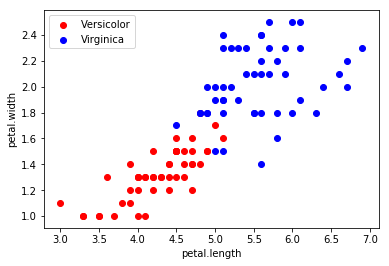

In [20]:
colors = ['red', 'blue']
for c, cls in zip(colors, classes):
    subsample = df.loc[df['variety'] == cls]
    plt.scatter(subsample[attr1], subsample[attr2], color=c)
    
plt.xlabel(attr1)
plt.ylabel(attr2)

plt.legend(classes)

In [21]:
y = y.replace(name_to_class_dict)
y = np.array(y).reshape(-1, 1)

In [22]:
print(f'Podaci:')
print(X[:10])
print(' ...')

print(f'Ciljne promenljive:')
print(y[:10])
print(' ...')

Podaci:
[[1.  4.7 1.4]
 [1.  4.5 1.5]
 [1.  4.9 1.5]
 [1.  4.  1.3]
 [1.  4.6 1.5]
 [1.  4.5 1.3]
 [1.  4.7 1.6]
 [1.  3.3 1. ]
 [1.  4.6 1.3]
 [1.  3.9 1.4]]
 ...
Ciljne promenljive:
[[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]]
 ...


In [23]:
# nn = NeuralNetwork(m, [3, 4], 1)
nn = NeuralNetwork(m, [2*m, 2*m], 1)
nn.print_network()
print()

nn.print_layer_mapper_sizes()
print()

nn.print_model()

~ Neural network ~
Layer 1:
[1. 1. 1.]
Layer 2:
[1. 1. 1. 1. 1.]
Layer 3:
[1. 1. 1. 1. 1.]
Layer 4:
[1.]

Dimenzije matrica modela koji mapiraju slojeve:
0 -> 1: 4 x 3
1 -> 2: 4 x 5
2 -> 3: 1 x 5

Model:
W_0: 0 -> 1
[[-0.41798633  0.24976649  0.59424556]
 [-0.34457016 -0.77065697 -0.54704246]
 [ 0.86494217  0.02111688  0.68137469]
 [-0.60453884 -0.0867309   0.40749368]]
W_1: 1 -> 2
[[-0.39368311 -0.95901051  0.80129983 -0.88909435 -0.97037788]
 [ 0.19514801  0.28349751  0.44634612 -0.86560306 -0.69053204]
 [ 0.15038036  0.27192591  0.46065975 -0.90476591 -0.87678262]
 [-0.11076895  0.78895343  0.74488594 -0.74284541  0.32271376]]
W_2: 2 -> 3
[[-0.85584071  0.69387345 -0.52760644  0.91017524  0.53066397]]


In [24]:
X_train, y_train, X_test, y_test = train_test_split(X, y)

Set sizes: 
train_size: 70, test_size: 30


In [25]:
print(f'X_train:')
print(X_train)
print()

print(f'y_train:')
print(y_train)
print()

print(f'X_test:')
print(X_test)
print()

print(f'y_test:')
print(y_test)

X_train:
[[1.  5.7 2.3]
 [1.  6.3 1.8]
 [1.  3.5 1. ]
 [1.  3.9 1.1]
 [1.  4.9 1.8]
 [1.  5.1 1.6]
 [1.  5.  2. ]
 [1.  5.5 2.1]
 [1.  4.6 1.4]
 [1.  4.2 1.3]
 [1.  4.7 1.6]
 [1.  4.2 1.2]
 [1.  5.6 1.8]
 [1.  5.3 1.9]
 [1.  3.5 1. ]
 [1.  4.  1.3]
 [1.  4.5 1.5]
 [1.  4.1 1. ]
 [1.  4.2 1.3]
 [1.  3.3 1. ]
 [1.  5.6 2.4]
 [1.  4.9 2. ]
 [1.  5.7 2.1]
 [1.  4.7 1.4]
 [1.  4.6 1.5]
 [1.  5.3 2.3]
 [1.  5.1 2. ]
 [1.  4.8 1.8]
 [1.  4.4 1.3]
 [1.  5.7 2.5]
 [1.  5.8 1.8]
 [1.  5.5 1.8]
 [1.  5.4 2.3]
 [1.  3.9 1.2]
 [1.  5.6 1.4]
 [1.  4.8 1.8]
 [1.  4.9 1.8]
 [1.  4.5 1.5]
 [1.  6.  2.5]
 [1.  5.8 1.6]
 [1.  6.7 2. ]
 [1.  4.4 1.2]
 [1.  4.5 1.3]
 [1.  5.9 2.3]
 [1.  5.1 1.8]
 [1.  4.  1.3]
 [1.  4.7 1.5]
 [1.  3.9 1.4]
 [1.  4.6 1.3]
 [1.  4.9 1.5]
 [1.  6.6 2.1]
 [1.  4.5 1.7]
 [1.  5.1 1.9]
 [1.  4.5 1.5]
 [1.  5.  1.5]
 [1.  6.  1.8]
 [1.  4.3 1.3]
 [1.  4.1 1.3]
 [1.  5.5 1.8]
 [1.  4.7 1.4]
 [1.  4.5 1.5]
 [1.  5.6 2.4]
 [1.  6.1 2.3]
 [1.  3.8 1.1]
 [1.  3.  1.1]
 [1.  4.3 1.3]
 

In [26]:
lambdas = [0] + [0.01 * (2**i) for i in range(11)]
print('lamda parameters:')
print(lambdas)

lamda parameters:
[0, 0.01, 0.02, 0.04, 0.08, 0.16, 0.32, 0.64, 1.28, 2.56, 5.12, 10.24]


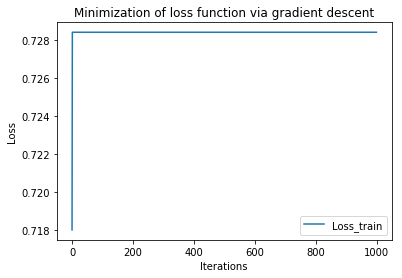

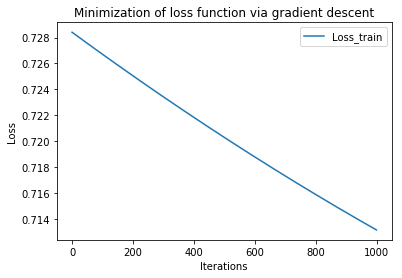

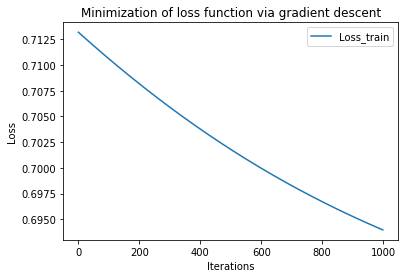

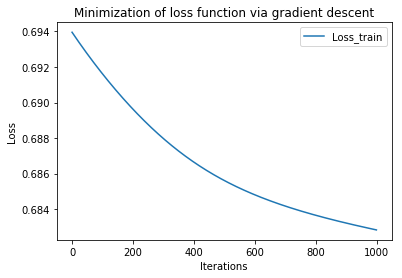

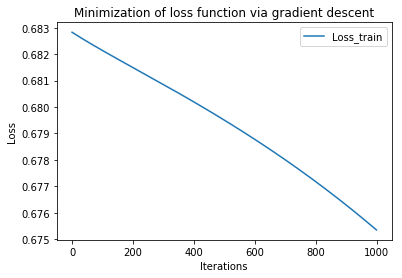

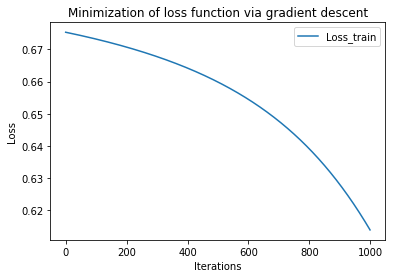

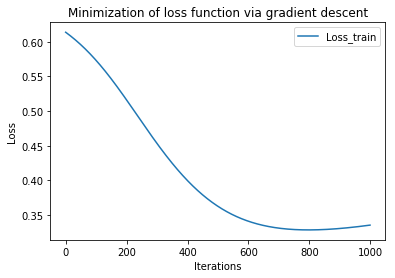

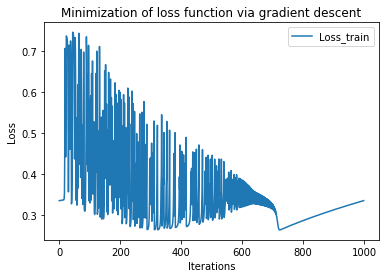

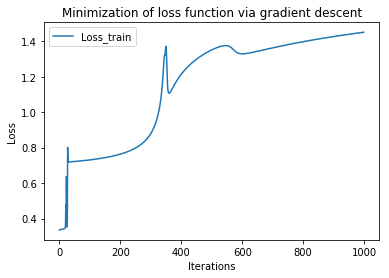

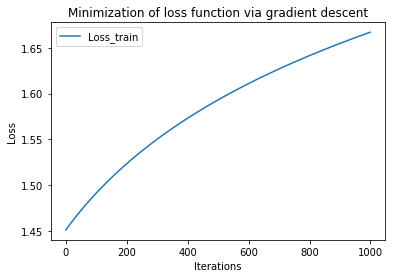

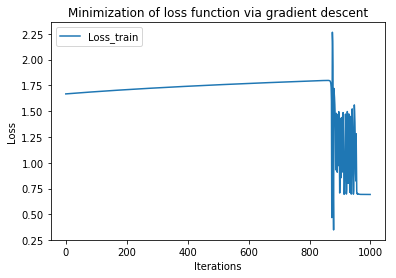

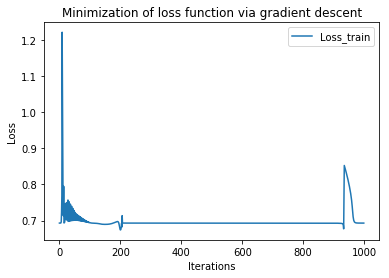

In [27]:
classifiers = [nn.fit(X_train, y_train, lambda_param, plot=True) for lambda_param in lambdas]

In [28]:
losses_test = [clf.loss(X_test, y_test, lambda_param) for clf, lambda_param in zip(classifiers, lambdas)]
print('Funkcije gubitka za svaki klasifikator posebno na test skupu:')
print(losses_test)

Funkcije gubitka za svaki klasifikator posebno na test skupu:
[0.7281041343837363, 0.7149153082495555, 0.6975658891473009, 0.6895146316501117, 0.6915412097738662, 0.6698372552698403, 1.0081145873670543, 2.457229029638941, 6.450400239609973, 12.558555310596903, 30.561007002653056, 71.0772611535192]


In [29]:
min_loss = float('inf')
best_clf = None

for i in range(len(losses_test)):
    if losses_test[i] < min_loss:
        min_loss = losses_test[i]
        best_clf = classifiers[i]
        
print(f'Min loss of best classifier on the test set: {min_loss}')
print(f'Best classifier\'s model:\n{best_clf.model}')

Min loss of best classifier on the test set: 0.6698372552698403
Best classifier's model:
[array([[-1.76796557, -0.09104584,  1.56505032],
       [-0.38516617, -0.91611039, -0.5880363 ],
       [ 1.52128215, -0.3814773 , -0.20287304],
       [-0.47571169, -0.3297353 ,  0.13660549]])
 array([[-0.23004864, -1.5170069 ,  0.83633086, -0.49741558, -0.84664733],
       [ 0.29016429,  0.71183982,  0.42372674, -0.94754408, -0.70375393],
       [-0.10493385,  1.75631866,  0.38357775, -1.82566153, -1.15862662],
       [-0.13664809,  1.47807136,  0.70685603, -0.97096502,  0.27063905]])
 array([[-0.94754408, -0.70375393, -0.10493385,  1.75631866,  0.38357775]])]


Ponovno iscrtavanje skupa podataka:


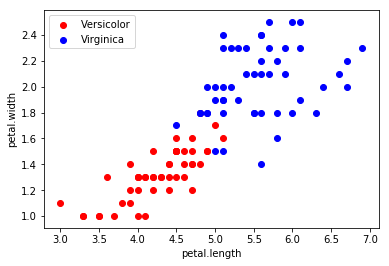

In [30]:
print('Ponovno iscrtavanje skupa podataka:')
colors = ['red', 'blue']
for c, cls in zip(colors, classes):
    subsample = df.loc[df['variety'] == cls]
    plt.scatter(subsample[attr1], subsample[attr2], color=c)
    
plt.xlabel(attr1)
plt.ylabel(attr2)

plt.legend(classes)

In [53]:
petal_length = float(input('Unesite petal.length:'))
petal_width = float(input('Unesite petal.width:'))

x = np.array([1, petal_length, petal_width])
print(x)

[1.  5.  1.4]


In [54]:
y_predict = best_clf.predict(x)
print(y_predict)

if y_predict < 0.5:
    print(class_to_name_dict[0])
else:
    print(class_to_name_dict[1])

0.4834180576072531
Versicolor
